In [1]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from google.colab import drive

In [2]:
#import deep learning tools
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout, Concatenate, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from skimage.io import imread
from keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [4]:
data_path = '/content/gdrive/MyDrive/data_acne/image'

In [5]:
image_size = (224, 224)
batch_size = 32

datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255, validation_split=0.2)
train_dir = tf.keras.preprocessing.image_dataset_from_directory(
    data_path,
    validation_split=0.2,
    subset="training",
    seed=0,
    image_size=image_size,
    batch_size=batch_size,
)
val_dir = tf.keras.preprocessing.image_dataset_from_directory(
    data_path,
    validation_split=0.2,
    subset="validation",
    seed=0,
    image_size=image_size,
    batch_size=batch_size,
)

Found 420 files belonging to 3 classes.
Using 336 files for training.
Found 420 files belonging to 3 classes.
Using 84 files for validation.


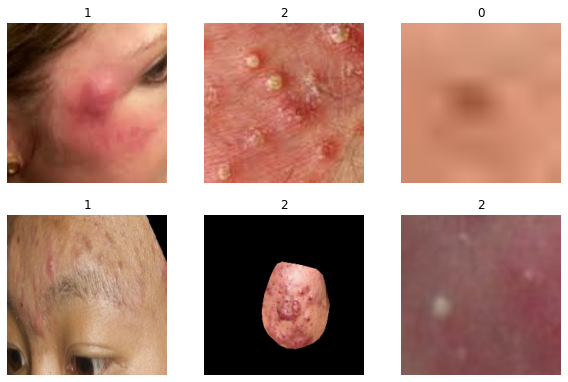

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in train_dir.take(1):
    for i in range(6):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [7]:
data_augmentation = keras.Sequential([
  keras.layers.RandomFlip("horizontal_and_vertical",seed=0),
  keras.layers.RandomRotation(0.1,seed=0),
])

In [8]:
class_names = ['Blackhead', 'Nodules','Pustules']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

In [9]:
print(class_names)

['Blackhead', 'Nodules', 'Pustules']


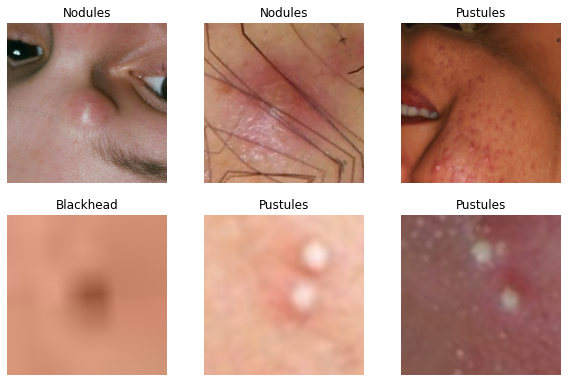

In [10]:
plt.figure(figsize=(10, 10))
for images, labels in train_dir.take(1):
  for i in range(6):
    augmented_image = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [11]:
augmented_train_ds = train_dir.map(
  lambda x, y: (data_augmentation(x, training=True), y))

In [12]:
train_ds = train_dir.prefetch(buffer_size=32)
val_ds = val_dir.prefetch(buffer_size=32)

In [ ]:
#num_classes = 3

#model = keras.Sequential([
 # keras.layers.Rescaling(1./255),
  #keras.layers.Conv2D(64, 3, activation='relu'),
  #keras.layers.MaxPooling2D(),
  #keras.layers.Conv2D(64, 3, activation='relu'),
  #keras.layers.MaxPooling2D(),
  #keras.layers.Conv2D(64, 3, activation='relu'),
  #keras.layers.MaxPooling2D(),
  #keras.layers.Flatten(),
  #keras.layers.Dense(256, activation='relu'),
  #keras.layers.Dense(num_classes)
#])

#model.compile(
 # optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
  #loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  #metrics=['accuracy'])

In [20]:
 # Import the inception model  
from tensorflow.keras.applications import MobileNetV2

# Creating pre-trained model
def create_pre_trained_model():
  trained_model = MobileNetV2(input_shape = (224, 224, 3),
                                  include_top = False, 
                                  weights = 'imagenet') 

  for the_layer in trained_model.layers:
    the_layer.trainable = False

  return trained_model
  


In [21]:
trained_model = create_pre_trained_model()

In [22]:
total_params = trained_model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in trained_model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 2,257,984 total parameters in this model.
There are 0 trainable parameters in this model.


In [23]:
def output_of_last_layer(pre_trained_model):
  last_desired_layer = trained_model.get_layer('block_14_project')
  print('last layer output shape: ', last_desired_layer.output_shape)
  last_output = last_desired_layer.output
  print('last layer output: ', last_output)

  return last_output

In [25]:
for the_layer in trained_model.layers:
    print(the_layer.name)

input_2
Conv1
bn_Conv1
Conv1_relu
expanded_conv_depthwise
expanded_conv_depthwise_BN
expanded_conv_depthwise_relu
expanded_conv_project
expanded_conv_project_BN
block_1_expand
block_1_expand_BN
block_1_expand_relu
block_1_pad
block_1_depthwise
block_1_depthwise_BN
block_1_depthwise_relu
block_1_project
block_1_project_BN
block_2_expand
block_2_expand_BN
block_2_expand_relu
block_2_depthwise
block_2_depthwise_BN
block_2_depthwise_relu
block_2_project
block_2_project_BN
block_2_add
block_3_expand
block_3_expand_BN
block_3_expand_relu
block_3_pad
block_3_depthwise
block_3_depthwise_BN
block_3_depthwise_relu
block_3_project
block_3_project_BN
block_4_expand
block_4_expand_BN
block_4_expand_relu
block_4_depthwise
block_4_depthwise_BN
block_4_depthwise_relu
block_4_project
block_4_project_BN
block_4_add
block_5_expand
block_5_expand_BN
block_5_expand_relu
block_5_depthwise
block_5_depthwise_BN
block_5_depthwise_relu
block_5_project
block_5_project_BN
block_5_add
block_6_expand
block_6_expand

In [26]:
last_output = output_of_last_layer(trained_model)

last layer output shape:  (None, 7, 7, 160)
last layer output:  KerasTensor(type_spec=TensorSpec(shape=(None, 7, 7, 160), dtype=tf.float32, name=None), name='block_14_project/Conv2D:0', description="created by layer 'block_14_project'")


In [27]:
# Creating model
def create_final_model(pre_trained_model, last_output):
  # Flatten the output layer to 1 dimension
  x = layers.Flatten()(last_output)
  x = layers.Dense(1024, activation='relu')(x)
  x = layers.Dropout(0.2)(x)    
  x = layers.Dense(5, activation='softmax')(x)          

  model = Model(inputs=pre_trained_model.input, outputs=x)
  
  model.compile(optimizer=Adam(learning_rate=0.001),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy']) 

  return model

In [30]:
# Saving model in a variable
base_model = create_final_model(trained_model, last_output)

# Inspect parameters
total_params = model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 9,074,373 total parameters in this model.
There are 8,034,309 trainable parameters in this model.


In [32]:
hist = base_model.fit(
    augmented_train_ds,
    validation_data=val_dir,
    epochs=100,
    shuffle=False
)

Epoch 1/100
11/11 [==============================] - 30s 2s/step - loss: 11.2811 - accuracy: 0.4494 - val_loss: 8.6315 - val_accuracy: 0.3214
Epoch 2/100
11/11 [==============================] - 3s 247ms/step - loss: 4.7168 - accuracy: 0.5000 - val_loss: 4.4727 - val_accuracy: 0.5833
Epoch 3/100
11/11 [==============================] - 3s 250ms/step - loss: 2.8738 - accuracy: 0.6250 - val_loss: 2.2881 - val_accuracy: 0.5357
Epoch 4/100
11/11 [==============================] - 3s 247ms/step - loss: 2.1358 - accuracy: 0.6280 - val_loss: 1.5278 - val_accuracy: 0.5238
Epoch 5/100
11/11 [==============================] - 3s 246ms/step - loss: 1.9289 - accuracy: 0.6190 - val_loss: 2.0240 - val_accuracy: 0.5714
Epoch 6/100
11/11 [==============================] - 3s 246ms/step - loss: 1.9421 - accuracy: 0.5833 - val_loss: 2.3536 - val_accuracy: 0.5952
Epoch 7/100
11/11 [==============================] - 3s 247ms/step - loss: 1.7200 - accuracy: 0.5833 - val_loss: 1.3056 - val_accuracy: 0.6071


In [38]:
import numpy as np
from sklearn.metrics import classification_report

predictions = np.array([])
true =  np.array([])

for x, y in val_ds:
  predictions = np.concatenate([predictions, np.argmax(base_model.predict(x), axis=-1)])
  true = np.concatenate([true, y.numpy()])

class_names = ['Blackhead', 'Nodules','Pustules']
print(classification_report(true, predictions, target_names=class_names,digits =4))

              precision    recall  f1-score   support

   Blackhead     0.7273    0.7273    0.7273        11
     Nodules     0.4634    0.7037    0.5588        27
    Pustules     0.7188    0.5000    0.5897        46

    accuracy                         0.5952        84
   macro avg     0.6365    0.6437    0.6253        84
weighted avg     0.6378    0.5952    0.5978        84



In [39]:
predictions

array([1., 2., 2., 1., 1., 0., 1., 2., 2., 1., 2., 2., 1., 2., 1., 1., 1.,
       2., 1., 2., 1., 0., 2., 1., 1., 1., 1., 1., 1., 1., 2., 1., 0., 2.,
       1., 2., 1., 2., 1., 1., 1., 0., 1., 2., 0., 1., 2., 1., 1., 1., 2.,
       2., 0., 2., 2., 0., 1., 2., 1., 0., 2., 2., 1., 2., 2., 1., 2., 1.,
       0., 1., 2., 1., 0., 1., 2., 2., 2., 2., 0., 1., 2., 1., 1., 1.])

In [40]:
true

array([1., 2., 1., 1., 2., 2., 1., 0., 2., 1., 2., 1., 1., 2., 2., 1., 1.,
       1., 1., 2., 2., 0., 2., 0., 2., 1., 2., 1., 2., 1., 2., 2., 0., 2.,
       2., 2., 1., 2., 2., 0., 1., 0., 1., 2., 0., 1., 1., 1., 1., 2., 2.,
       1., 2., 1., 2., 0., 2., 2., 2., 0., 2., 2., 1., 2., 2., 2., 1., 2.,
       0., 1., 2., 2., 2., 2., 1., 2., 2., 2., 0., 2., 2., 2., 2., 2.])

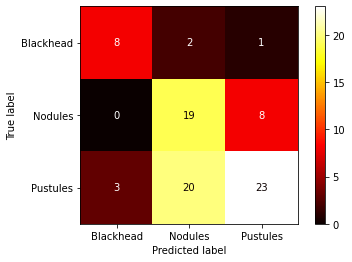

In [41]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(true, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_names)
disp.plot(cmap='hot')
plt.savefig('confusionmatrix.png')
plt.show()

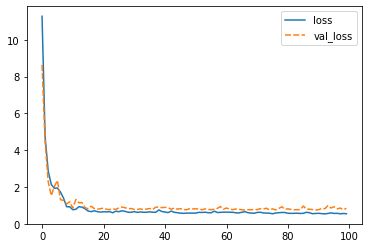

In [43]:
sns.lineplot(data={idx: hist.history[idx] for idx in ['loss', 'val_loss']})

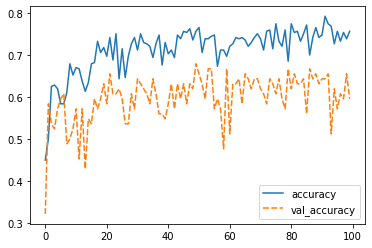

In [44]:
sns.lineplot(data={idx: hist.history[idx] for idx in ['accuracy', 'val_accuracy']})

In [56]:
# Saving model into h5 format
from datetime import datetime
date = datetime.now().strftime("%Y_%m_%d-%I-%M-%S-%p")
base_model.save(f'H5 Models/model_1_mobilenetv2 ({date}).h5')